# **2005-2020 Yılları Arasında Gerçekleşen Siber Olaylar**

Bu projede, 2005-2020 yılları arasında gerçekleşen gerçek siber olayların belirli bir kısmınının kaydedildiği dataset'teki veriler incelenmiştir. Veriler grafik halinde görselleştirilerek raporlanma sağlanmış, bir sonraki yılda gerçekleşebilecek olan saldırıların tahmini yapılmaya çalışılmıştır.

Veri işleme ve görselleştirme kısımlarında matlab, pandas, numpy, seaborn, wordcloud kütüphaneleri, veri tahmin aşamasında yapay zekayı desteklemek için sklearn ve csv kütüphaneleri kullanılmıştır.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS

import numpy as np

import csv

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

## **Veriye ilk bakış**

Bu aşamada verilerin yer aldığı csv formatındaki dataset dosyası okunarak, işlemlere başlamadan önce verileri anlamak ve anlamlandırmak amaçlanmıştır.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/cyber-operations-incidents.csv')

df.head() # veri setimizdeki ilk 5 satırı listeliyoruz

,Title,Date,Affiliations,Description,Response,Victims,Sponsor,Type,Category,Sources_1,Sources_2,Sources_3
0,Attack on Austrian foreign ministry,2/13/2020,Turla,The suspected Russian hackers conducted a week...,Confirmation https://www.theregister.co.uk/2...,Austrian Foreign Ministry,Russian Federation,Espionage,Government,https://www.theregister.co.uk/2020/02/14/austr...,https://www.bmeia.gv.at/en/the-ministry/press/...,NaN
1,Spear-phishing campaign against unnamed U.S. g...,1/23/2020,Konni Group,The suspected North Korean threat actor Konni ...,NaN,Employees of the U.S. government,Korea (Democratic People's Republic of),Espionage,Government,https://unit42.paloaltonetworks.com/the-fractu...,NaN,NaN
2,Australian Signals Directorate,4/6/2020,NaN,Responsible for attacking infrastructure that ...,NaN,NaN,Australia,Data destruction,Private sector,https://www.minister.defence.gov.au/minister/l...,https://www.zdnet.com/article/australia-on-the...,NaN
3,Catfishing of Israeli soldiers,2/16/2020,APT-C-23,The Hamas-associated threat actor APT-C-23 tar...,Hack Back https://www.bleepingcomputer.com/n...,Israeli Defense Forces (IDF) soldiers,"Palestine, State of",Espionage,Military,https://www.bleepingcomputer.com/news/security...,https://research.checkpoint.com/2020/hamas-and...,NaN
4,Targeting of U.S. companies and government age...,8/10/2020,Fox Kitten,Iranian hackers attacked high-end networking e...,NaN,"U.S. government agencies, U.S. companies",Iran (Islamic Republic of),Espionage,"Government, Private sector",https://www.cybersafe.news/fbi-warns-about-ira...,https://www.zdnet.com/article/fbi-says-an-iran...,NaN


Veri setindeki sütunların kontrolünü sağlamak için `df.info()` komutu kullanılmıştır.


In [ ]:
df.info() # veri setimizdeki sütunların kontrolünü sağlıyoruz

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481 entries, 0 to 480
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         481 non-null    object
 1   Date          474 non-null    object
 2   Affiliations  347 non-null    object
 3   Description   481 non-null    object
 4   Response      86 non-null     object
 5   Victims       453 non-null    object
 6   Sponsor       439 non-null    object
 7   Type          447 non-null    object
 8   Category      458 non-null    object
 9   Sources_1     475 non-null    object
 10  Sources_2     355 non-null    object
 11  Sources_3     168 non-null    object
dtypes: object(12)
memory usage: 45.2+ KB


Veri setinde boş değerlerin olup olmadığı hakkında bilgi sağlayabilmek için `df.isnull().values.any()` komutu kullanılmıştır. Eğer veride bilgi içermeyen kısımlar varsa, bu boş değerlerin sayısına ulaşmak için `df.isnull().sum()` komutu kullanılacaktır.

In [ ]:
df.isnull().values.any() # verilerde boşluk var mı ?


True

In [ ]:
df.isnull().sum() # hangi sütunlarda ne kadar boşluk var

Title             0
Date              7
Affiliations    134
Description       0
Response        395
Victims          28
Sponsor          42
Type             34
Category         23
Sources_1         6
Sources_2       126
Sources_3       313
dtype: int64

### **WordCloud**

Bu aşamada, wordcloud yapısını kullanarak sahip olduğumuz tüm veriler arasında en çok bulunan kelimeler görüntülenmiş, Verilerin içeriği hakkında genel bir bilginin tablo olarak sunulması amaçlanmıştır.

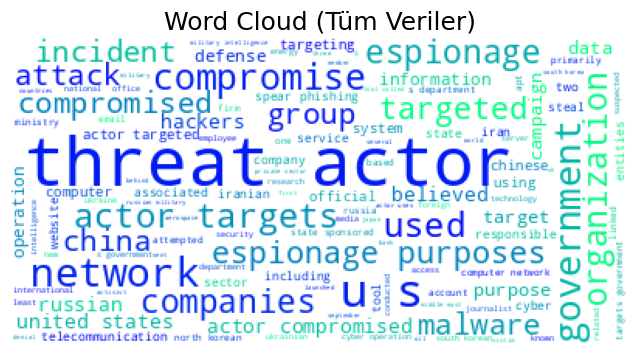

In [ ]:
word_string = " ".join(df["Description"].str.lower()) # description sütunundaki verileri küçük karakter formatında birleştiriyoruz
wordcloud = WordCloud(stopwords=STOPWORDS, colormap='winter', background_color="white").generate(word_string) # wordcloud oluşturma kodu

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Word Cloud (Tüm Veriler)', fontsize=18, c='black')
plt.show()

## **Veri İnceleme**

Bu aşamada veriler görselleştirilerek, genelden özele doğru bir inceleme yapılmıştır. Bilgilerin görselleştirilme kısmında pasta grafiği (pie), sütun grafiği (barh ve bar plot), çizgi grafiği (line plot), saçılım grafiği (scatter plot) kullanılmıştır.

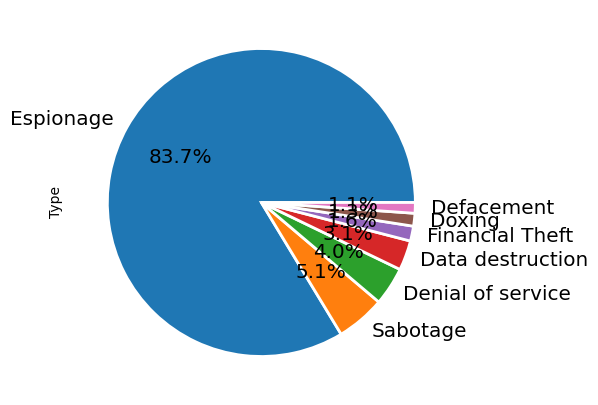

In [ ]:
# Pasta grafiği
ax = df['Type'].value_counts().plot.pie(figsize=(6, 5), autopct='%1.1f%%', wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'}, textprops={'size': 'x-large'})

Veri setinde yer alan; 2005-2020 Yılları arasında gerçekleşen saldırı türlerinin sayısı görselleştirilmiştir.

```
Espionage           = Casusluk      (Gizli bilgileri bulma veya bir işlemi takip etme)
Sabotage            = Sabotaj       (Korku veya caydırma amacı içeren saldırılar)
Denial of Service   = Servis Reddi  (Sunucu Çökertme)
Data Destruction    = Veri İmhası
Financial Theft     = Finansal Hırsızlık
Doxing              = Gizli Bilgileri Bulup Yayma
Defacement          = Arayüz Görünümünü Değiştirme Saldırıları
```

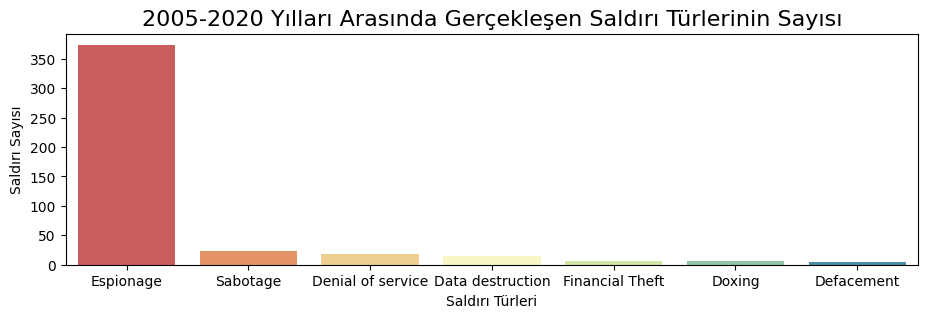

In [ ]:
saldiri_turleri = df['Type'].value_counts().index # saldırı türlerini değişkene alıyoruz

fig, ax = plt.subplots(1, 1, figsize=(11, 3)) # plot grafik oluşturuyoruz
sns.countplot(data=df, x='Type', order=saldiri_turleri, palette='Spectral') # veriyi tabloya yerleştirerek renk ayarlaması yapıyoruz

ax.set(xlabel='Saldırı Türleri') # alt kısım için yazı
ax.set(ylabel='Saldırı Sayısı') # sol kısım için yazı

plt.title('2005-2020 Yılları Arasında Gerçekleşen Saldırı Türlerinin Sayısı', fontsize=16, c='black') # grafik başlığı
plt.show()


## **Veri Filtreleme**

Bu aşamada veriler tarih, ülke ismi gibi spesifik kriterlere göre incelenerek görselleştirilmiştir.

In [ ]:
while True:
    girilen_yil = input("2005-2020 arasında bir tarih giriniz: ")
    try:
        girilen_yil = int(girilen_yil)
    except Exception as e:
        print(f"Hata!\n{e.args}")
        continue
    if 2005 <= girilen_yil <= 2020:
        girilen_yil = str(girilen_yil)
        break
    else:
        print("Geçersiz tarih girdiniz")

baslangic_tarihi = girilen_yil+'-01-01'
bitis_tarihi = girilen_yil+'-12-31'

2005-2020 arasında bir tarih giriniz: 2020


Date sütununda yer alan tarih verilerinin pandas kütüphanesi tarafından "tarih" olarak görülebilmesi ve bazı özel fonksiyonların kullanılabilmesi için "datetime" objesine dönüştürülmesi gerekmektedir.

Date sütununda yer alan veriler pandas'ta bulunan "datetime" objesine çevrilmiştir. Date kısmı boş olan satırlar ise veri setinden silinmiştir.

In [ ]:
df["Date"] = pd.to_datetime(df["Date"])  # pandas datetime objesine çeviriyoruz (sort fonksiyonu vs. çalışması için)
df_yillar = df[pd.notnull(df['Date'])] # Date kısmı boş olan satırların silinmesini sağlıyoruz

Seçilen yıl ile ilgili veri setinde filtreleme işlemi aşağıdaki kod bloğunda yer almaktadır.

In [ ]:
yil_verileri = (df_yillar['Date'] > baslangic_tarihi) & (df_yillar['Date'] <= bitis_tarihi) # başlangıç ve bitiş tarihi aralığındaki tarihleri alıyorum
yil_verileri = df_yillar.loc[yil_verileri] # string değer olduğu için loc kullanıldı | yil_verileri sorgusuna göre verileri getir
yil_verileri = yil_verileri.reset_index(drop=True)
yil_verileri = yil_verileri.drop(['Sources_1', 'Sources_2', 'Sources_3'], axis=1) # siber olaylarla ilgili kaynaklara ihtiyaç duymadığımız için bu verileri siliyoruz

Aşağıda seçilen tarihteki wordcloud verisi görselleştirilerek, ilgili tarihteki verilere genel bir bakış atmak amaçlanmıştır.

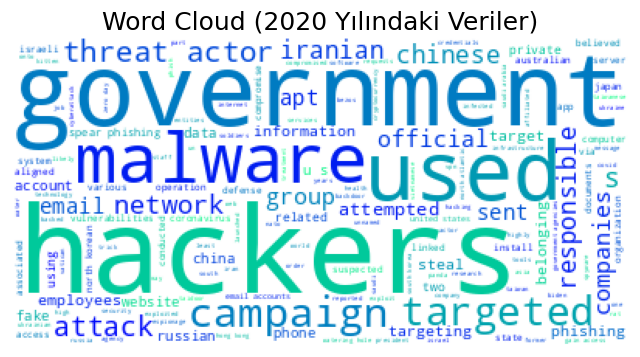

In [ ]:
word_string = " ".join(yil_verileri['Description'].str.lower())
wordcloud = WordCloud(stopwords=STOPWORDS, colormap='winter', background_color="white").generate(word_string)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.clf()
plt.imshow(wordcloud)

plt.axis('off')
plt.title(f'Word Cloud ({girilen_yil} Yılındaki Veriler)', fontsize=18, c='black')
plt.show()

Aşağıda seçilen tarihteki tehdit aktörleri listelenmiştir.

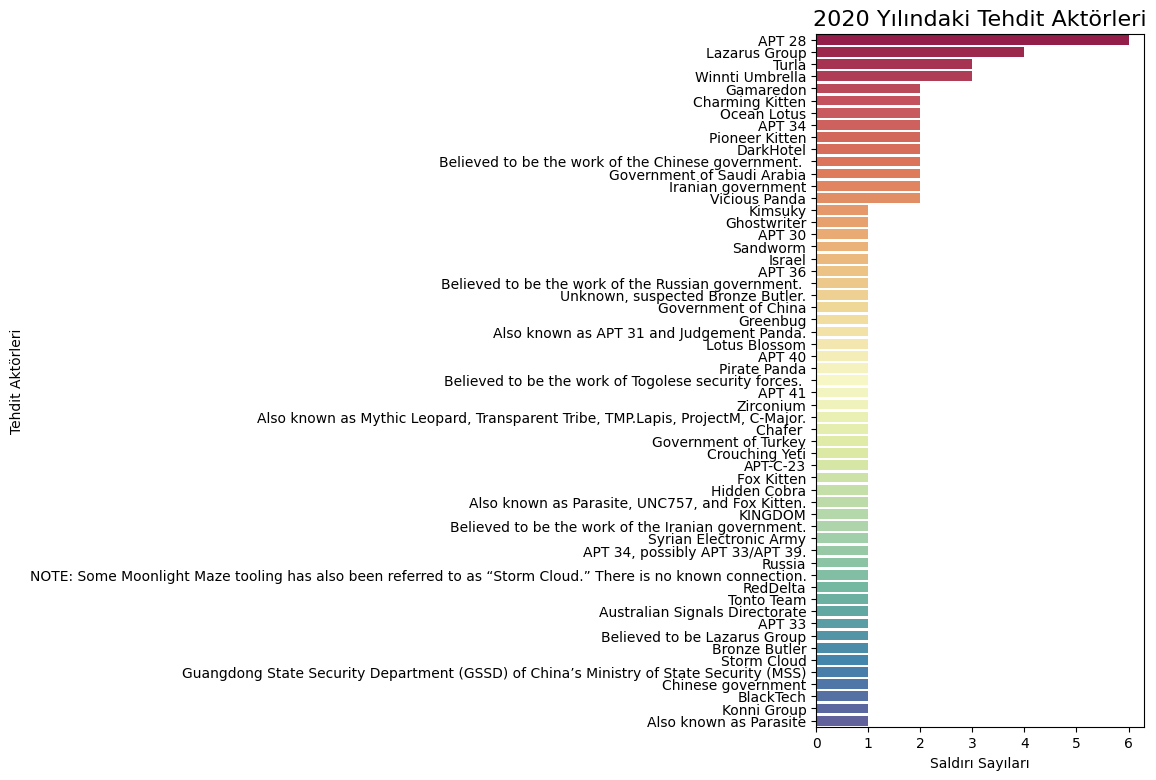

In [ ]:
siber_olaylar_yil = yil_verileri["Affiliations"].value_counts()

fig, ax = plt.subplots(1, 1, figsize=(8, 9)) # plot grafik oluşturuyorum
sns.countplot(data=yil_verileri, y='Affiliations', order=yil_verileri["Affiliations"].value_counts().index, palette="Spectral") # datayı tabloya yerleştiriyorum, renk ayarlaması yapıyorum

ax.set(xlabel='Saldırı Sayıları') # alt kısım için yazı
ax.set(ylabel='Tehdit Aktörleri') # sol kısım için yazı
plt.title(f'{girilen_yil} Yılındaki Tehdit Aktörleri', fontsize=16, c='black')
plt.subplots_adjust(left=0.56, right=0.97)
plt.show()

Aşağıda seçilen tarihteki saldırılara en çok sponsor olan tüzel kişiler listelenmiştir.

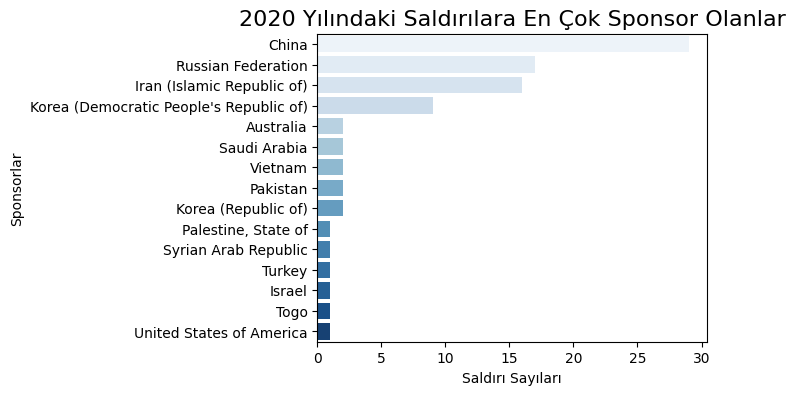

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.countplot(data=yil_verileri, y='Sponsor', order=yil_verileri["Sponsor"].value_counts().index, palette='Blues') # (alternatif: palette='mako')

ax.set(xlabel='Saldırı Sayıları') # alt kısım için yazı
ax.set(ylabel='Sponsorlar') # sol kısım için yazı

plt.title(f'{girilen_yil} Yılındaki Saldırılara En Çok Sponsor Olanlar', fontsize=16, c='black')
plt.subplots_adjust(left=0.25)
plt.show()


Aşağıda yer alan kod bloğunda seçilen ülkenin yıllara göre siber saldırıya maruz kalma sayısını görebilmek amaçlanmıştır.

Lütfen ülkenin tam ismini giriniz: United States
Lütfen ülkenin kısaltmasını giriniz: U.S


<Axes: title={'center': 'Yıllara Göre Maruz Kalınan Siber Saldırı Sayısı (United States)'}, xlabel='Date'>

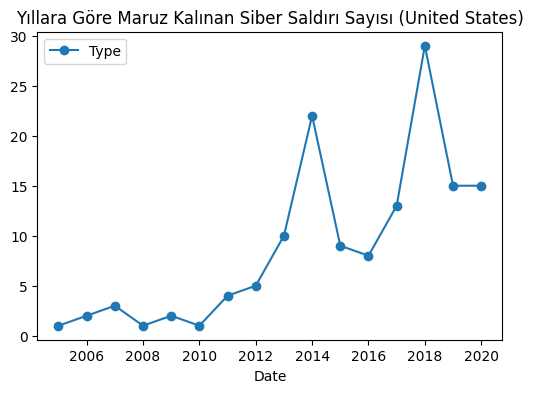

In [ ]:
secilen_ulke = input("Lütfen ülkenin tam ismini giriniz: ")
ulke_kisaltmasi = input("Lütfen ülkenin kısaltmasını giriniz: ")

ulkedeki_veriler = df[df["Victims"].astype(str).str.contains('|'.join([secilen_ulke, ulke_kisaltmasi]), case=False)]
yila_gore_hacklenme = ulkedeki_veriler.groupby([df["Date"].dt.year]).agg({'Type': 'count'})

yila_gore_hacklenme.plot(style="-o", figsize=(6, 4), title=f"Yıllara Göre Maruz Kalınan Siber Saldırı Sayısı ({secilen_ulke})")

## **Veri Tahmini**

Bu aşamada veri tahminini gerçekleştirmek üzere yapay zekanın performansını artırmak istenmiş, buna bağlı olarak regresyon işlemi uygulanmıştır.

**Regresyon nedir ?**

Regresyon denklemi birden fazla değişken arasındaki ilişkiyi analiz etmeye ve buna bağlı olarak yeni tahminler üretilebilmesine olanak sağlar.

2020 yılındaki "Defacement" (arayüz görünümünü değiştirme) saldırısına yönelik verileri hesaplamak için kalan saldırı türleri bağımsız değişken olarak kabul edilir ve bu veriler kullanılarak bir regrasyon denklemi oluşturulur.

bu sayede "Defacement" sayısı 2020 yılı için tahmin edilir. Ardından 2020 yılındaki gerçek değer ile arasındaki fark incelenir ve MSE , RMSE değerleri bulunur. Bu işlem bağımsız değişkenlere olduğu sürece her yılda tahmin yapmak için kullanılabilir.

```
MSE = ortalama hatanın karesi
RMSE = ortalama karekök sapması
```


Kısaca özetlemek gerekirse; 2021 yılındaki verileri tahmin etmek istiyorsak öncelikle elimizde var olan değerleri tahmin etmemiz ve program ne kadar hata veriyor onu tespit etmemiz gerekir. Hata payını en aza indirdikten sonra gelecek yılları tahmin etmek daha kolay olacaktır.

Gelecek yıl "Defacement" arayüz saldırısının ne kadar olacağını tahmin edebilmek için kullanacağımız regrasyon denkleminde ihtiyaç duyduğumuz şey hangi yıl hangi saldırıların ne kadar olduğudur. Bu yüzden aşağıdaki kod bloğunda sahip olunan verilerle yeni bir CSV dosyası yaratılmıştır.

In [ ]:
fields = list(df['Type'].value_counts().index)
fields.insert(0, "Year")
rows = []

for year in range(2005, 2021):
    baslangic_tarihi = f'{year}-01-01'
    bitis_tarihi = f'{year}-12-31'

    yil_verileri = (df_yillar['Date'] > baslangic_tarihi) & (df_yillar['Date'] <= bitis_tarihi) # başlangıç ve bitiş tarihi aralığındaki tarihleri alıyorum
    yil_verileri = df_yillar.loc[yil_verileri] # string değer olduğu için loc kullanıldı | yil_verileri sorgusuna göre verileri getir

    year_fields = list(yil_verileri["Type"].value_counts().index)
    year_rows = list(yil_verileri["Type"].value_counts().reset_index(name="count")["count"])
    year_output = list(zip(year_fields, year_rows))

    result = [0]*len(fields) # [0, 0, 0, 0, 0, 0, 0]
    result[0] = year # [2007, 0, 0, 0, 0, 0, 0]
    
    for i,f in enumerate(fields):
        for yf in year_output:
            if f == yf[0]:
                result[i] = yf[1]

    rows.append(result)

# CSV dosyamızın görüntüsü
print(fields)
for e in rows:
  print(e)

# dosya yazma işlemi
with open('predictdata.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(fields)
    write.writerows(rows)



['Year', 'Espionage', 'Sabotage', 'Denial of service', 'Data destruction', 'Financial Theft', 'Doxing', 'Defacement']
[2005, 1, 0, 0, 0, 0, 0, 0]
[2006, 3, 0, 0, 0, 0, 0, 0]
[2007, 7, 0, 3, 0, 0, 0, 0]
[2008, 6, 0, 1, 0, 0, 0, 0]
[2009, 3, 0, 1, 0, 0, 0, 0]
[2010, 6, 1, 1, 0, 0, 0, 1]
[2011, 12, 0, 2, 0, 0, 0, 0]
[2012, 7, 0, 3, 2, 0, 0, 0]
[2013, 17, 0, 1, 0, 0, 0, 0]
[2014, 31, 1, 0, 1, 0, 1, 0]
[2015, 30, 1, 1, 0, 0, 0, 1]
[2016, 26, 2, 1, 3, 1, 0, 0]
[2017, 36, 2, 2, 2, 2, 0, 1]
[2018, 64, 5, 0, 0, 1, 5, 0]
[2019, 56, 4, 2, 4, 0, 0, 0]
[2020, 64, 6, 0, 2, 3, 0, 2]


Oluşturulan predictdata isimli csv dosyasını olarak okuma işlemi yapılmıştır. Makine öğrenmesi modelini beslemek üzere X_train, y_train, X_test ve y_test değişkenleri oluşturulmuştur.

X_train = 2005-2019 arasındaki saldırı türleri

y_train = 2005-2019 arasındaki "defacement" saldırı değeri

x_test = 2020 yılındaki saldırı türleri

y_test = 2020 yılındaki "defacement" saldırı değeri

In [ ]:
predictdata = pd.read_csv('predictdata.csv')
X_train = predictdata.iloc[:15, 1:7] # 2005-2019 arası diğer saldırı türleri
y_train = predictdata.iloc[:15, 7] # 2005-2019 arası "defacement" saldırı değerleri
X_test = predictdata.iloc[15:16, 1:7] # 2020 yılındaki diğer saldırı türleri
y_test = predictdata.iloc[15:16, 7] # 2020 yılındaki "defacement" saldırı değeri

(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((15, 6), (15,), (1, 6), (1,))

#### **MULTIPLE LINEAR REGRESSION**

Modelin toplanan veriye ne kadar uyum gösterdiğini bulmak üzere 2005-2019 arasındaki bütün verilerimi fit fonksiyonuna gönderiyoruz.

2020 yılındaki saldırı türlerini vererek 2020 yılındaki defacement saldırısını tahmin etmek için predict(tahmin) fonksiyonunu kullanıyoruz.

MSE ve RMSE değerlerine erişerek programın efektifliğini ölçüyoruz.

In [ ]:
reg = LinearRegression()

reg.fit(X_train, y_train) # 2005-2019 arasındaki tüm veriler

y_pred_linear = reg.predict(X_test) # 2020 yılındaki diğer saldırı türlerini vererek, 2020 yılındaki defacement saldırısını tahmin etmesini istiyoruz


# tahmin edilen değer ile gerçek değer arasındaki hata payını buluyoruz
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)


# MSE = ortalama hata karesi
# RMSE = ortalama hatanın karekökü

print(f"MSE: {mse_linear}\nRMSE: {rmse_linear}")

MSE: 0.19513216218378301
RMSE: 0.4417376621749418


In [ ]:
types = list(df['Type'].value_counts().index) # saldırı türleri

data_2021 = [0]*len(types) # [0, 0, 0, 0, 0, 0, 0]
data_2021[0] = "2021"

for i, type in enumerate(types):
    #sadece 1 satır için tahmin işlemi yapacağız, bu yüzden reshape kullanıyoruz
    X = predictdata["Year"].values.reshape(-1, 1)
    #saldırı türünün değerlerini kullanarak bir sonraki değerini tahmin etmeye çalışacağız 
    y = predictdata[str(type)].values

    model = LinearRegression()
    model.fit(X, y)

    #tahmin işlemi için predict fonksiyonunun kullanarak 2021 yılındaki veriyi tahmin etmeye çalışıyoruz
    prediction_2021 = model.predict([[2021]])
    #çıkan sonucu saldırı türünün id'sine göre listeye ekliyoruz
    data_2021[i] = prediction_2021[0]

data_2021

[59.04999999999927,
 4.274999999999977,
 1.0500000000000007,
 2.400000000000034,
 1.4499999999999886,
 1.0999999999999943,
 0.7999999999999972]

In [ ]:
data2 = {"Types": types,
         "2021": data_2021}

df3 = pd.DataFrame(data2)

print(df3)

               Types    2021
0          Espionage  59.050
1           Sabotage   4.275
2  Denial of service   1.050
3   Data destruction   2.400
4    Financial Theft   1.450
5             Doxing   1.100
6         Defacement   0.800


Aşağıdaki grafikte 2005-2020 yılları arasında gerçekleşmiş saldırıların türlere göre sayıları gösterilmiştir.

<Axes: xlabel='Year'>

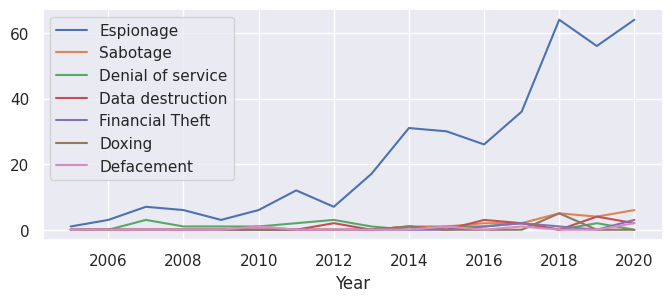

In [ ]:
predictdata.set_index("Year").plot(grid=True, figsize=(8, 3))

Aşağıdaki grafikte ise 2021 yılı için makine öğrenmesi ile geliştirmiş olduğumuz algoritmanın tahmin ettiği, saldırı türlerine ait sayılar yer almaktadır.

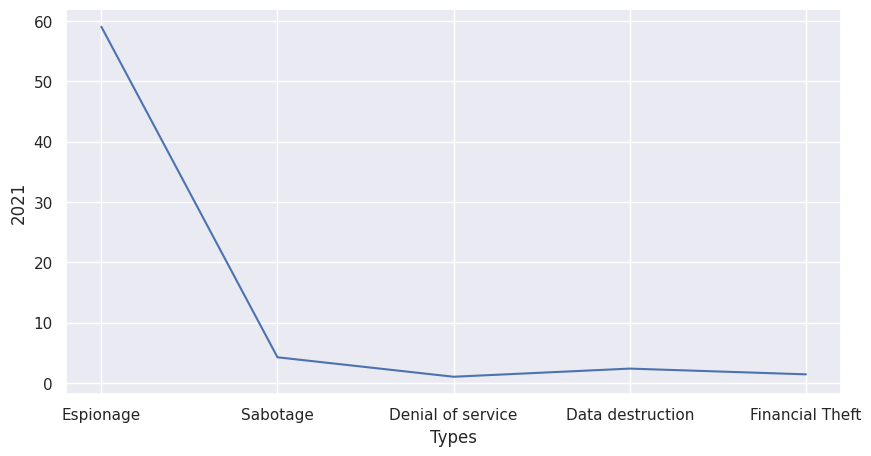

In [ ]:
sns.lineplot(x=df3.head()["Types"], y=df3.head()["2021"], sizes=(3, 3))
sns.set(rc={'figure.figsize': (10, 5)})